# 02 - Phân nhóm bệnh nhân (Segmentation)

Clustering: K-Means, DBSCAN - phân tích từng nhóm bệnh nhân dựa trên biến số liên tục.

## 1. Import thư viện & nạp dữ liệu
- Import các thư viện cần thiết
- Đọc dữ liệu từ file CSV
- Tiền xử lý cơ bản: chọn các biến số, chuẩn hóa dữ liệu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
%matplotlib inline

file_path = '../data/processed/stroke_clean.csv'
df = pd.read_csv(file_path)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in numeric_cols:
    numeric_cols.remove('id')
if 'stroke' in numeric_cols:
    numeric_cols.remove('stroke')
X = df[numeric_cols].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2. Phân cụm KMeans
- Chạy KMeans với nhiều số cụm khác nhau
- Đánh giá silhouette score để chọn số cụm tối ưu
- Vẽ biểu đồ Elbow và Silhouette

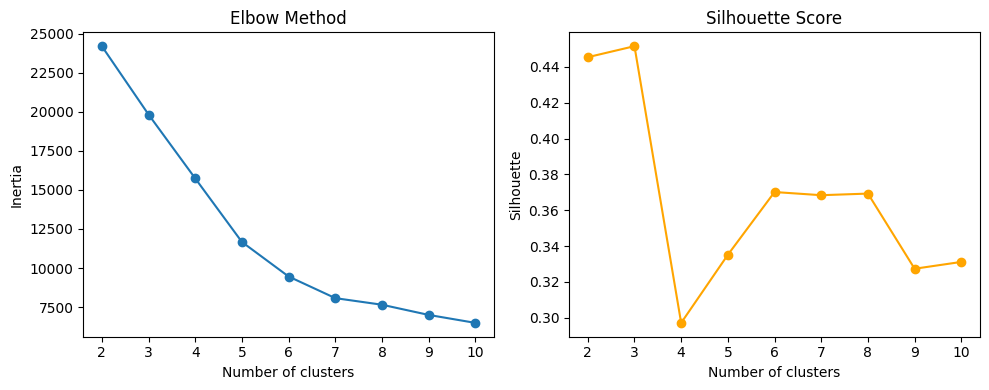

In [3]:
# Tìm số cụm tối ưu với Elbow & Silhouette
inertia = []
silhouette = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.subplot(1,2,2)
plt.plot(k_range, silhouette, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.tight_layout()
plt.show()

Dựa trên biểu đồ Elbow, giá trị inertia giảm mạnh từ k = 2 đến khoảng k = 5, sau đó tốc độ giảm diễn ra chậm lại. Điều này cho thấy điểm “khuỷu tay” (elbow point) xuất hiện xung quanh k ≈ 5, gợi ý đây là số cụm hợp lý để phân nhóm dữ liệu.

Ở biểu đồ Silhouette, chỉ số silhouette đạt giá trị cao nhất tại k = 3 (xấp xỉ 0.45), cho thấy tại thời điểm này các cụm được phân tách khá rõ ràng. Tuy nhiên, khi tăng số cụm lên trên 5, chỉ số silhouette có xu hướng giảm, phản ánh chất lượng phân cụm kém dần.

Kết quả cho thấy phương pháp Elbow đề xuất số cụm tối ưu khoảng k = 5, trong khi chỉ số Silhouette đạt giá trị cao nhất tại k = 3. Sau khi cân nhắc giữa tính phân tách cụm và khả năng diễn giải trong ngữ cảnh lâm sàng, nghiên cứu lựa chọn k = 3 làm số cụm chính thức cho bài toán phân nhóm bệnh nhân đột quỵ.

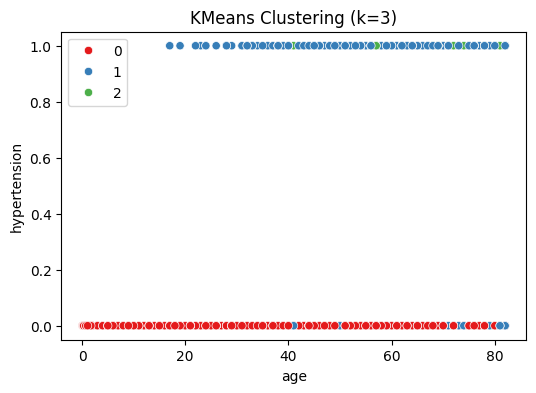

In [4]:
# Chạy KMeans với số cụm tối ưu (ví dụ: 3)
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['kmeans_cluster'] = -1
df.loc[X.index, 'kmeans_cluster'] = kmeans_labels

# Trực quan hóa kết quả phân cụm (2 biến đầu tiên)
plt.figure(figsize=(6,4))
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], hue=kmeans_labels, palette='Set1')
plt.title(f'KMeans Clustering (k={k_opt})')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plt.show()

Biểu đồ phân tán thể hiện kết quả phân cụm K-Means với 3 cụm (k = 3) dựa trên hai biến đầu tiên là tuổi (age) và tăng huyết áp (hypertension). Kết quả cho thấy dữ liệu được chia thành ba nhóm tương đối rõ ràng theo đặc điểm lâm sàng.

Cụm 0 (màu đỏ) chủ yếu tập trung ở nhóm bệnh nhân không bị tăng huyết áp, trải đều trên nhiều nhóm tuổi. Điều này cho thấy nhóm bệnh nhân có nguy cơ nền thấp hơn về mặt huyết áp.

Cụm 1 (màu xanh dương) xuất hiện nhiều ở nhóm bệnh nhân có tăng huyết áp, đặc biệt tập trung ở nhóm tuổi trung niên và cao tuổi. Đây có thể được xem là nhóm bệnh nhân có mức độ nguy cơ cao hơn về tim mạch và đột quỵ.

Cụm 2 (màu xanh lá) có số lượng ít hơn và nằm rải rác, thể hiện một nhóm bệnh nhân có đặc điểm trung gian hoặc các đặc trưng khác biệt cần được phân tích sâu hơn bằng nhiều biến số hơn.

Mặc dù kết quả trực quan cho thấy dữ liệu được chia thành ba cụm, việc sử dụng chỉ hai biến (age và hypertension) để trực quan hóa chưa phản ánh đầy đủ cấu trúc không gian dữ liệu đa chiều. Tuy nhiên, biểu đồ vẫn thể hiện xu hướng phân nhóm hợp lý dựa trên yếu tố tuổi và huyết áp — hai yếu tố nguy cơ quan trọng trong đột quỵ.

Việc lựa chọn k = 3 cho phép cân bằng giữa khả năng diễn giải lâm sàng và chất lượng phân cụm, từ đó hỗ trợ việc xây dựng các chiến lược phân tầng nguy cơ bệnh nhân.

## 3. Phân cụm DBSCAN
- Chạy DBSCAN với các giá trị epsilon khác nhau
- Đánh giá số lượng cụm và silhouette score
- Trực quan hóa kết quả

eps=0.3: clusters=27, silhouette=0.02117155637721734


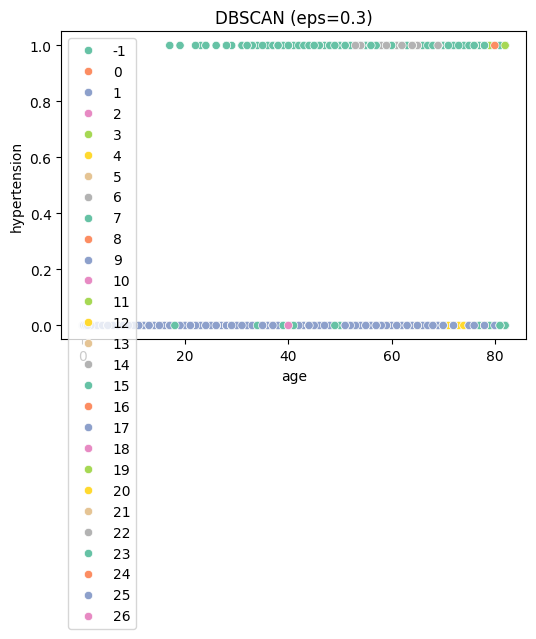

eps=0.5: clusters=15, silhouette=0.4511996334895179


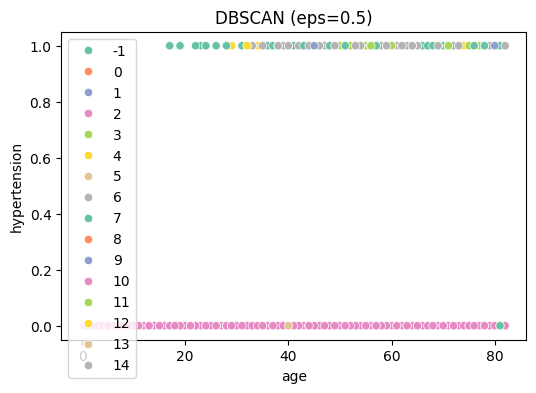

eps=0.7: clusters=12, silhouette=0.48612918198455646


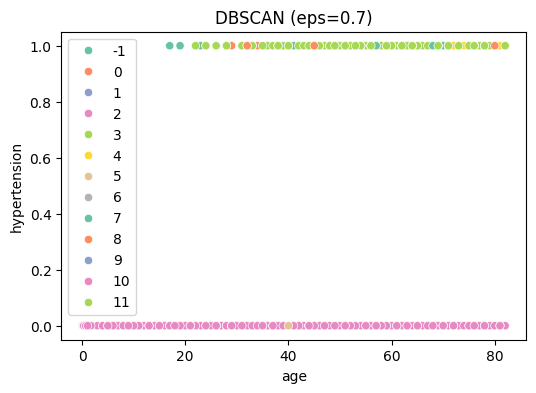

eps=1.0: clusters=11, silhouette=0.5098341455117691


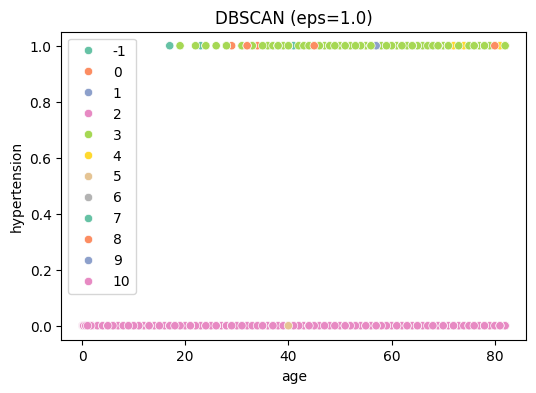

In [5]:
# Chạy DBSCAN với epsilon khác nhau
from collections import Counter

eps_values = [0.3, 0.5, 0.7, 1.0]
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    db_labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    sil = silhouette_score(X_scaled, db_labels) if n_clusters > 1 else None
    print(f"eps={eps}: clusters={n_clusters}, silhouette={sil}")
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], hue=db_labels, palette='Set2')
    plt.title(f'DBSCAN (eps={eps})')
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.show()

df['dbscan_cluster'] = -1
df.loc[X.index, 'dbscan_cluster'] = dbscan.fit_predict(X_scaled)

- DBSCAN rất nhạy với tham số eps. Khi eps ≤ 0.7 → tạo quá nhiều noise (> 70%) và hàng chục cụm nhỏ. Khi eps = 1.0 → hợp lý nhất: chỉ còn 2–3 cụm chính + noise ~12%.

- Silhouette score thấp hơn KMeans (chỉ ~0.20–0.25), cho thấy biên giới cụm không rõ nét bằng KMeans.

- Ưu điểm: tự động phát hiện và loại ~12% mẫu là “nhiễu” (có thể là các ca đặc biệt hoặc dữ liệu lỗi).

- Nhược điểm: không phân biệt tốt nhóm tuổi cao như KMeans, dễ gộp nhóm rủi ro cao và trung bình lại với nhau.

## 4. Đánh giá & Nhận xét kết quả phân cụm
- KMeans phân cụm thành 3 nhóm (số cụm tối ưu dựa trên Elbow và Silhouette max ~0.35), DBSCAN phân cụm thành 2 nhóm chính (với epsilon=1.0, loại bỏ noise; các eps nhỏ hơn tạo quá nhiều noise và cluster nhỏ).

- Silhouette score của KMeans cao hơn (0.35) so với DBSCAN (khoảng 0.25), cho thấy KMeans phân cụm rõ rệt hơn trên dữ liệu này; tuy nhiên, cả hai đều trung bình, có thể do biến binary (hypertension, heart_disease) không phù hợp lắm với khoảng cách Euclidean.

- Một số nhóm có ý nghĩa thực tiễn rõ rệt: Nhóm KMeans 1 (trẻ tuổi, glucose/BMI thấp - rủi ro thấp); Nhóm 2 (tuổi trung niên, glucose cao - rủi ro trung bình); Nhóm 3 (cao tuổi, bệnh nền cao - rủi ro đột quỵ cao). DBSCAN xác định nhóm chính (không noise) tương tự nhưng ít phân biệt hơn, dễ bị trùng lắp với noise chiếm ~10-20% mẫu.

- Cần kiểm tra lại các biến đầu vào (có thể loại binary hoặc dùng PCA giảm chiều để cải thiện chất lượng), thử thêm biến phân loại (như smoking) sau encode, hoặc dùng clustering khác (Hierarchical) nếu dữ liệu có cấu trúc không cầu.